In [1]:
import os
os.chdir("/content/drive/Shareddrives/yujung kim/Study/Python/time_series/notebook/03_Deeplearning_models")

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta, time
from tqdm.auto import tqdm

In [3]:
import transformer_v2 as tf

from torch.utils.data import DataLoader
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim

In [4]:
with open('../../data/pv_forecast.pickle', 'rb') as f:
    pv = pickle.load(f)

# scaling

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
power_scaler = MinMaxScaler()
power_scaler.fit(pv[['power']])
pv['power_scale'] = power_scaler.transform(pv[['power']])

In [7]:
x_scaler = MinMaxScaler()
x_scaler.fit(pv[['dwpt', 'rhum', 'wspd', 'pres']])
pv[['dwpt', 'rhum', 'wspd', 'pres']] = x_scaler.transform(pv[['dwpt', 'rhum', 'wspd', 'pres']])

In [8]:
pv = pv.set_index('datetime')

In [9]:
tz = timezone(timedelta(hours=-6))
pv_train = pv.loc[:datetime(2006,12,21,23,tzinfo=tz)]
pv_test = pv.loc[datetime(2006,12,15,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)]

# data loader

- torch 에서 LSTM 의 경우 
  - input: (seq_len, batch, input_size)
  - output: (seq_len, batch, num_directions * hidden_size) 

In [10]:
iw = 24*7
ow = 24
num_feature = 5

train_dataset = tf.windowDataset(pv_train[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)
test_dataset = tf.windowDataset(pv_test[['power_scale', 'rhum', 'dwpt', 'wspd', 'pres']], input_window=iw, output_window=ow, num_feature=num_feature, stride=24)

train_loader = DataLoader(train_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=16)

In [11]:
len(train_loader)

6

In [12]:
len(test_loader)

1

# transformer

- 시계열 데이터 transformer 적용이 목표이기 때문에 최대한 간단한 구조로 적용

- positional embedding 적용 x

- encoder, decoder 모두 1개의 layer

- target seq의 경우 teacher force prop 1/0 두가지로 적용

# teacher forcing = 0

In [13]:
# !pip install wandb

In [14]:
import wandb

In [15]:
wandb.init(name='basic', project="transformer", entity="yyyyyjkim")

wandb: Currently logged in as: yyyyyjkim (use `wandb login --relogin` to force relogin)


In [16]:
wandb.config = {
    "learning_rate": 0.001,
    "epochs": 5,
    "d_model": 5,
    "nhead": 5,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dim_feedforward": 128
}

In [17]:
device='cpu'
model = nn.Transformer(d_model=wandb.config["d_model"], 
                       nhead=wandb.config["nhead"], 
                       num_encoder_layers=wandb.config["num_encoder_layers"], 
                       num_decoder_layers=wandb.config["num_decoder_layers"], 
                       dim_feedforward=wandb.config["dim_feedforward"], 
                       batch_first=True).to(device)

optimizer = optim.Adam(model.parameters(), lr = wandb.config['learning_rate'])
criterion = nn.MSELoss()

In [18]:
# 파라미터 수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,256 trainable parameters


In [19]:
# 파라미터 초기화
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
        )
        (linear1): Linear(in_features=5, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=5, bias=True)
        (norm1): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((5,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=5, out_features=5, bias=True)
    

In [20]:
wandb.watch(model, log='all', log_freq=10)

# target_mask = model.generate_square_subsequent_mask(24).to(device)

pbar = tqdm(range(wandb.config['epochs']))
for epoch in pbar:
    pred, true, train_loss = tf.train(model, train_loader, optimizer, criterion, max_len=24, device='cpu')
    pred, true, test_loss = tf.predict(model, test_loader, criterion, max_len=24, device='cpu')
    wandb.log({"train_loss": train_loss, "test_loss": test_loss})

    pbar.set_postfix(loss=f"train_loss: {train_loss:.5f}")

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
wandb.finish()

test_loss,▂█▁▁▄
train_loss,█▅▃▁▁
test_loss,0.05539
train_loss,0.09364


In [22]:
pred = power_scaler.inverse_transform(pred[:,:,0].reshape(-1,1))
true = power_scaler.inverse_transform(true[:,:,0].reshape(-1,1))

In [23]:
pv_test = pv.loc[datetime(2006,12,22,00,tzinfo=tz):datetime(2006,12,30,23,tzinfo=tz)].copy()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


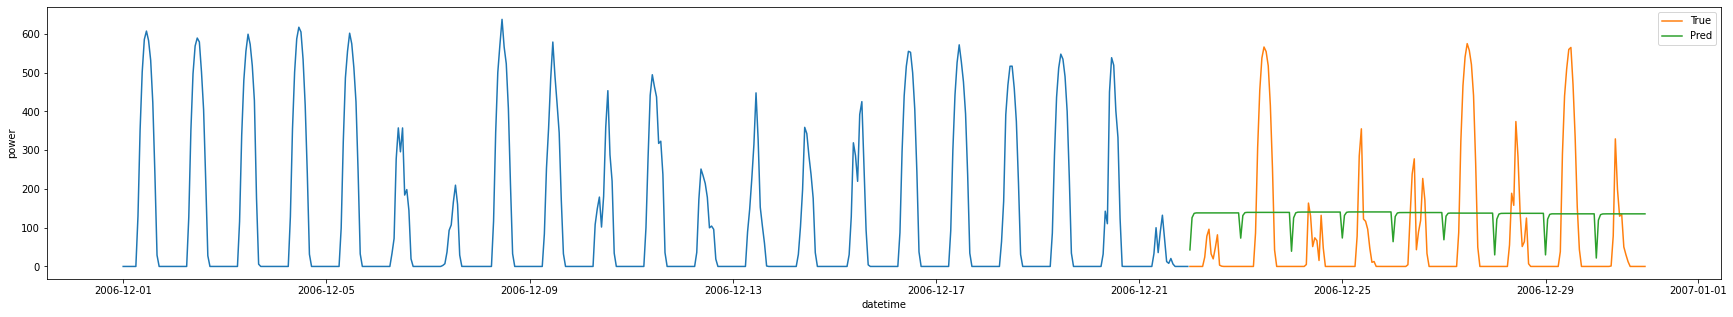

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30,5))

sns.lineplot(pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):].index, pv_train.loc[datetime(2006,12,1,00,tzinfo=tz):]['power'])
sns.lineplot(pv_test.index, true.reshape(-1), label='True')
sns.lineplot(pv_test.index, pred.reshape(-1), label='Pred')
plt.legend()